MICRO-452 Basics of mobile robotics

Project Report



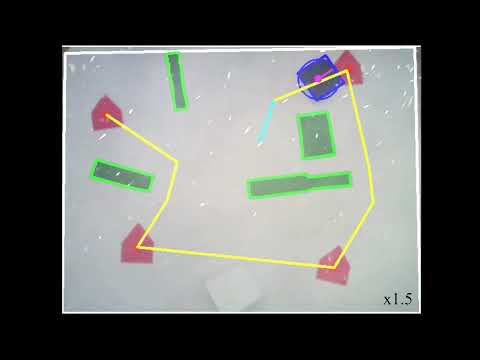

In [1]:
from IPython.display import YouTubeVideo
santo_christmas_hero = YouTubeVideo('50Xt3Dh3GrM')
display(santo_christmas_hero)

In [5]:
import numpy as np

### Table of Contents

* [Introduction](#introduction)
* [Filtering](#filtering)
    * [General, filtering](#genfiltering)
    * [Choosing a filter](#filterchoice)
    * [Mathematical model](#mathmodel)
    * [Filter initialization](#filterinit)
    * [Testing](#testing)
    * [Conclusion on filtering](#filterconcl)

### Introduction <a class="anchor" id="introduction"></a>
The present project takes place in the Basics of mobile robotics course. The goal is to programm a mobile Thymio robot to perform a chosen task. The programm must use computer vision, global navigation, local navigation and filtering to determine the robot's position and make it achieve its objectives.

We decided to programm Santo, an unfortunately blue santa that unfortunately has no gifts but is dedicated to its job of visiting all the houses it can.

The programm uses an overhead camera to detect the different obstacles, the houses and Santo's position. A global navigation module allows Santo to do some path planning to reach every target. Finally, a Kalman filter using the robot's position from the camera and odometry allows the Thymio to know and correct its position in real time.


# Computer vision


## Set-up

Houses are represented by red shapes, grass by green shapes, the neighbourhood is white, and our thymio is in dark blue. We added a white obstacle (which is the box of the Thymio) that will not be seen by the camera to see how the Thymio handle it on is own.

<img src="pictures/raw_map.jpg" alt="Drawing" style="width: 400px;"/>

## 2. Computer vision

### Libraries
Using OpenCV and Shapely libraries, we get a livestream from the webcam and we use the first frame of the video to detect most of the things that we need to plan the navigation of the robot (see sect ------). 

In [ ]:
from math import pi
import numpy as np 
from cv2 import cv2 as cv
from matplotlib import pyplot as plt
from shapely.geometry import MultiPolygon, Polygon 
from shapely.geometry import LineString, Point

### Colour detection and colour space
All object detection made during this project is based on colour segmentation, for a matter of simplicity. We first used the default colour space of OpenCv which is BGR to choose ranges used to detect the objects, but these ranges were very sensible to lightning, and the computer vision was not always accurate, so we searched for a colour space suiting better our purpose. BGR colour space is bad for our task because we want to separate chromatic information (Is it red? blue?) and brightness. We found that the HSV (Hue, Saturation, Value) colour space was good for that purpose and OpenCv provides a simple function for converting from one colour space to the other.[1]

Colour frames have some random variations in brightness or hue among pixels. So, to have a better detection of colours, we first blurred the image to have less noise using gaussian blur.  
We used masks to isolate every needed colour, then, we obtained the contours of the detected objects. We applied an area threshold to be sure to detect only significant objects. 


In [ ]:
def get_color_contour(frame, color):
    if color == "white":
        lower_color = np.array([0,0,128]) 
        upper_color = np.array([179,46,247]) 
    elif color == "blue":
        lower_color = np.array([96,63,62]) 
        upper_color = np.array([130,255,255])
    elif color == "red":
        lower_color = np.array([130,100,100]) 
        upper_color = np.array([179,255,255])
    elif color == "green":
        lower_color = np.array([45,60,0])
        upper_color = np.array([90,140,140])
    else:
        return [0]
    frame = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    mask_white = cv.inRange(frame, lower_color, upper_color)
    contours, _= cv.findContours(mask_white, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    
    return contours


### Planar geometry
To prepare the visibility graph used for navigation, we used a planar geometry library: Shapely [3]. We approximated every contour by a polygon using the function approxPolyDP function from OpenCv. For the epsilon parameter, which represents the maximum distance between the original curve and the approximation, we set a number depending on the perimeter of the contour, which was found to do quite good approximations. This means the smaller the obstacle, the more the approximation will try to be precise. Then we used the buffer function from Shapely to get an approximate representation of all the points at a distance equal to the radius of the smallest circle fitting the robot of the polygon approximate of the contour of the obstacles and map. This allowed us to consider the robot as a point, being sure that it would not touch obstacles or leave the map.

### Detecting the map
The map is defined as the biggest white contour based on area. By definition, there is only one map. The frame to display is resized based on the smallest rectangle containing this contour. The map is dilated towards its interior by the radius of the robot to ensure that it stay in the map.

In [ ]:
def polygon(c):
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.005 * peri, True)
    
    return approx

def cam_get_bounded_frame(frame, show_contour = False, show_polygone = False):
    contours_white = get_color_contour(frame, "white")

    if contours_white: #if list is not empty
        contour = max(contours_white, key = cv.contourArea)
        #print(contour)
    else:
        contour = [[0,0],[1,0]]
    x_rect,y_rect,w_rect,h_rect = cv.boundingRect(contour)

    frame_limits = [y_rect, y_rect+h_rect, x_rect, x_rect+w_rect] #min_y, max_y, min_x, max_x

    contour = contour-[x_rect,y_rect]

    if show_contour:
        cv.drawContours(frame[frame_limits[0]: frame_limits[1], frame_limits[2]: frame_limits[3]], contour, -1, (255,255,255),3)
    
    if show_polygone:
        white_pts = np.squeeze(polygon(contour))
        draw_polygone(frame, white_pts, "white")

    return frame_limits, contour

def cam_get_contour(map_contour, radius):
    map_contour_poly = Polygon(np.squeeze(polygon(map_contour)))
    dilated_map = map_contour_poly.buffer(-radius, join_style=2,single_sided=True)
    return map_contour_poly, dilated_map

### Detecting Santo (Thymio robot)
The pose of the robot is defined as being the center of the smallest circle enclosing the robot. We also use the diameter of this circle in pixels to get a scale from pixels to millimeters (we measured the diagonal of the robot as being 140mm which represents two radii). We also use the smallest rectangle enclosing the robot to get the angle of the robot.

In [ ]:
def cam_locate_thymio(frame, show_contour = False, show_circle = False):
    contours_blue = get_color_contour(frame, "blue")

    max_blue_area = 0
    thymio_pos = [0,0]
    thymio_angle = 0.0
    scale_mm = 1
    radius = 1
    blue_zones_counter = 0
    for contour_blue in contours_blue:
        area = cv.contourArea(contour_blue)
        if area > 1000 and area > max_blue_area:
            blue_zones_counter += 1
            max_blue_area = area
            (x,y),radius = cv.minEnclosingCircle(contour_blue)
            (rect_cent, (rect_width, rect_height), rect_angle) = cv.minAreaRect(contour_blue)
            center = (int(x),int(y))
            scale_mm = 140/(2*radius)
            radius = int(radius)
            thymio_pos = center
            if show_contour:
                cv.drawContours(frame, contour_blue, -1, (255,0,0),3)
            if show_circle:
                cv.circle(frame,center,radius,(255,0,0),2)
                cv.circle(frame, center, 7, (255, 0, 0), -1)
                box = cv.boxPoints((rect_cent, (rect_width, rect_height), rect_angle))
                box_points = list((int(point[0]),int(point[1])) for point in box)
                draw_polygone(frame,box_points,"blue")
            #takes the angle from the rectangle framing the thymio that is the closest to the noisy angle
            noisy_angle = np.arctan2(center[1] - rect_cent[1],rect_cent[0] - center[0]) #is in rad
            possible_angles = np.array(list((-rect_angle + s*90.)*pi/180. for s in range(4)))
            angles_errors = list(abs(np.arctan2(np.sin(noisy_angle - poss_angle), np.cos(noisy_angle - poss_angle))) for poss_angle in possible_angles)
            thymio_angle = possible_angles[np.argmin(angles_errors)]
    thymio_visible = True

    if blue_zones_counter == 0:
        thymio_visible = False

    return thymio_pos, thymio_angle, thymio_visible, radius, scale_mm


def convert_to_mm(y_axis_size, scale, coords_px):
    return [coords_px[0]*scale, (y_axis_size-coords_px[1])*scale]

def convert_to_px(y_axis_size, scale, coords_mm):
    return [int(coords_mm[0]/scale), int(y_axis_size-coords_mm[1]/scale)]

### Detecting the houses (targets)

Targets are not defined as polygons but as points. The goal of the Thymio is to reach their centroids which we computed using the moments function from OpenCv. We also only consider the targets that are in the dilated map and outside of the dilated polygons.

In [ ]:
def cam_get_targets(frame, show_contour = False, show_center = False):
    contours_red = get_color_contour(frame, "red")

    target_list = []
    for contour_red in contours_red:
        area = cv.contourArea(contour_red)
        if area > 1000:
            M = cv.moments(contour_red)
            if M['m00'] != 0:
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
                target_list.append((cx,cy))
            if show_contour:
                cv.drawContours(frame, contour_red, -1, (0,0,255),3)
            if show_center:
                cv.circle(frame, (cx, cy), 7, (0,0,255), -1)

    return target_list

def reachable_targets(targets_list,dilated_map,dilated_obstacle_list):
    for target in targets_list:
        if not Point(target).within(dilated_map):
            targets_list.remove(target)
        else:
            for x in dilated_obstacle_list:
                 if Point(target).within(x):
                    targets_list.remove(target)

    return targets_list

### Detecting the obstacles
As for the map, we get all the contours, and we dilate them by the radius of the robot this time, in the exterior direction.

In [ ]:
def cam_get_obstacles(frame, radius, show_contour = False, show_polygone = False):
    contours_green = get_color_contour(frame, "green")

    area_obstacles = MultiPolygon()
    dilated_obstacle_list = []
    for contour_green in contours_green:
        area = cv.contourArea(contour_green)
        if area > 1000:
            pts = np.squeeze(polygon(contour_green))
            pol = Polygon(pts)
            dilated_obstacle = pol.buffer(radius, join_style=2 ,single_sided=True)
            dilated_obstacle_list.append(dilated_obstacle)
            area_obstacles = area_obstacles.union(dilated_obstacle)
            if show_contour:
                cv.drawContours(frame, contour_green, -1, (0,255,0),3)
            if show_polygone:
                draw_polygone(frame, pts, "green")

    obstacles_boundary = []

    if type(area_obstacles) != Polygon:
        for geom in area_obstacles.geoms:    
            xo, yo = geom.exterior.xy
            obstacles_boundary.append(zip(xo,yo))

    obstacles_list = []
    for obstacle in obstacles_boundary :
        obstacles_list.append(list(obstacle))

    return obstacles_list, dilated_obstacle_list

### Visibility graph
We decided to use a visibility graph, because it allows us to get the shortest path in Euclidean distance, and it is quite easy to implement since the camera can localize all the obstacles, targets, and Santo at the start. 

We used a dictionary to store, for each vertex ( Thymio and targets centroids, vertices of the polygon approximation of the obstacles), the points that are reachable by following a simple line on the map, checking if the line linking the two vertices is on the map and does not go through an obstacle. Using this visibility graph, we have been able to determine the path for which the Thymio covers the smallest distance possible while going to every target. Better solutions exist taking into account the computational time, but for our application, we didn't need to make the program faster so we sticked to the easiest solution which is effective.


In [ ]:
def visible(a,b, polygon_obstacle, polygon_map):
    visible = 1
    line = LineString([a,b])
    for x in polygon_obstacle:
        within_obstacle = line.within(x)
        crosses_obstacle = line.crosses(x)
        if within_obstacle == True or crosses_obstacle == True:
            visible = False     
    in_map = polygon_map.contains(line)
    if in_map == False:
        visible = False
    return visible

def distance(a,b):
    dist = np.linalg.norm(np.array(a)-np.array(b))
    return(dist)    

# Returns dictionnary containing for the key the index of the vertex of interest 
# and for the value, other vertices with distance that are valid paths for the robot
def vis_graph(start,targets,obstacles,polygon_obstacle,polygon_map):
    graph = {}
    start_idx = 0
    obstacles = [item for sublist in obstacles for item in sublist]
    targets_idx_list = list(range(1,len(targets)+1))
    vertices_with_rep = [start] + targets + obstacles
    vertices = []
    for i in vertices_with_rep : 
        if i not in vertices: 
            vertices.append(i)

    for vtx1_idx, vtx1 in enumerate(vertices):
        for vtx2_idx, vtx2 in enumerate(vertices):
            if vtx1_idx != vtx2_idx:
                if visible(vtx1,vtx2,polygon_obstacle,polygon_map)==1:
                    if vtx1_idx in graph :
                        graph[vtx1_idx].append([vtx2_idx,distance(vtx1,vtx2)])
                    else:
                        graph[vtx1_idx] = [(vtx2_idx,distance(vtx1,vtx2))]
                else:
                    if not(vtx1_idx in graph):
                        graph[vtx1_idx] = []

    return graph, start_idx, targets_idx_list, vertices

### Results

Let's visualize what we have just done! Here are some functions to draw on the frame everything we discussed.

In [ ]:
def draw_polygone(frame, polygone_points, color):
    if color == "white":
        color_RGB = (255,255,255)
    elif color == "green":
        color_RGB = (0,255,0)
    elif color == "blue":
        color_RGB = (255,0,0)

    for i in range(len(polygone_points)-1):
        cv.line(frame, polygone_points[i], polygone_points[i+1], color_RGB, 3)
    cv.line(frame, polygone_points[i+1], polygone_points[0], color_RGB, 3)


In [ ]:
def draw_analyze_frame(frame, show_options, dilated_obstacle_list, dilated_map, visibility_graph, vertices):
    blurred_frame = cv.GaussianBlur(frame, (5,5), cv.BORDER_DEFAULT)

    #show_option 0: show contours
    #show_option 1: show estimated contours
    _, map_contour = cam_get_bounded_frame(blurred_frame, show_options[0], show_options[1])
    thymio_pos, thymio_angle, thymio_visible, thymio_radius, _ = cam_locate_thymio(blurred_frame, show_options[0], show_options[1])
    thymio_state = [thymio_pos[0], thymio_pos[1], thymio_angle]

    cam_get_targets(blurred_frame, show_options[0], show_options[1])
    cam_get_obstacles(blurred_frame, thymio_radius, show_options[0], show_options[1])

    #show_option 2: show dilated polygones
    if show_options[2]:
        for dilated_obstacle in dilated_obstacle_list:
            x_obst, y_obst = dilated_obstacle.exterior.xy
            dilated_obst_poly = list((int(point[0]),int(point[1])) for point in list(zip(x_obst, y_obst)))
            draw_polygone(blurred_frame, dilated_obst_poly, "green")

        x_map, y_map = dilated_map.exterior.xy
        dilated_map_poly = list((int(point[0]),int(point[1])) for point in list(zip(x_map, y_map)))
        draw_polygone(blurred_frame, dilated_map_poly, "white")

    #show_option 3: show visibility graph
    if show_options[3]:
        for i in visibility_graph:
            for j in visibility_graph[i]:
                cv.line(blurred_frame, [int(vertices[i][0]), int(vertices[i][1])] , [int(vertices[j[0]][0]), int(vertices[j[0]][1])], (100,100,100), 2)
                #print(vertices[i], vertices[j[0]])
    return blurred_frame, thymio_state, thymio_visible

Object_detection function calls a lot of the functions we previously explained. 

In [ ]:
def object_detection(frame):
    #blur image to have less noise
    blurred_frame = cv.GaussianBlur(frame, (5,5), cv.BORDER_DEFAULT)
    #find the map boundaries
    frame_limits, map_contour = cam_get_bounded_frame(blurred_frame)
    #reduce the working frame to the boundaries
    bounded_frame = blurred_frame[frame_limits[0]: frame_limits[1], frame_limits[2]: frame_limits[3]]
    #locate the robot
    thymio_pos, thymio_angle, thymio_visible, thymio_radius, scale_mm = cam_locate_thymio(bounded_frame)
    thymio_state = [thymio_pos[0], thymio_pos[1], thymio_angle]
    #reduce the boundaries so the whole robot stays inside when the center is on the "dilated_map"
    map_contour_polygone, dilated_map = cam_get_contour(map_contour, thymio_radius)
    #locate the targets
    targets_list = cam_get_targets(bounded_frame)
    #locate the obstacles
    obstacles_list, dilated_obstacle_list  = cam_get_obstacles(bounded_frame, thymio_radius)
    #select only reachable targets
    targets_list = reachable_targets(targets_list,dilated_map,dilated_obstacle_list)


    return thymio_state,targets_list,obstacles_list,dilated_obstacle_list,dilated_map, frame_limits, scale_mm

In [ ]:
    show_contours = True
    show_polygones = True
    show_dilated_polygones = True
    show_visibility_graph = True
    show_option = [show_contours, show_polygones, show_dilated_polygones, show_visibility_graph]
    
    frame = cv.imread('Thymio_images/raw_map.jpg')
    thymio_state,targets_list,obstacles_list,dilated_obstacle_list,dilated_map, frame_limits, convert_px_mm = object_detection(frame)
    bounded_frame = frame[frame_limits[0]: frame_limits[1], frame_limits[2]: frame_limits[3]]
    visibility_graph,start_idx,targets_idx_list,vertices = vis_graph([thymio_state[0], thymio_state[1]],targets_list,obstacles_list,dilated_obstacle_list,dilated_map)
    modified_frame, thymio_state, thymio_visible = draw_analyze_frame(bounded_frame, show_option, dilated_obstacle_list, dilated_map, visibility_graph, vertices)
    
    modified_frame_rgb = cv.cvtColor(modified_frame, cv.COLOR_BGR2RGB)
    
    %matplotlib inline
    plt.rcParams['figure.figsize'] = [26, 13]
    plt.imshow(modified_frame_rgb)
    plt.show()
    

# Path planning
The goal of the path planning is to find the shortest path for Santo to travel to all houses. It takes as input the visibility graph of the map, and returns the optimal path, which is a list of coordinates for Santo to follow. This problem is divided in 3 parts:
* Simplifiying the graph
* Solving a Travelling Salesman Problem
* Reconstructing the optimal path

Let's see how it works with an example:

![title](pictures/vis_graph.png)

### Simplifying the graph

We want to simplify the graph by only keeping the indices of Santo and of the targets. We also want all of them to be connected. To do that, we will apply the dijkstra algorithm multiple times, to find the distance (and the path, used later) between each pair of points of interest (here points of interest are the start point and the target points).

For the example above, we take a visibility graph where the start index is 4, and the targets indices are 0 and 3. We want the distance between the vertices 4 and 0, 4 and 3, 0 and 3.

The function "create_distance_path_matrix" stores this information in matrices:

Input:
* Visibility graph
* Start index
* Target indices

Output:
* Matrix storing the distance between all points of interest
* Matrix storing the path between all points of interest

We can divide by two the number of calculations if we use the fact that the distance from index "x" to "y" is the same as from "y" to "x", and that the path is just reversed.

In [ ]:
def create_distance_path_matrix(visibility_graph,start_idx,targets_idx_list):
    #we treat start as an objective, from which we start
    targets_idx_list.insert(0, start_idx)

    nb_interest_point = len(targets_idx_list)
    distance_matrix = np.zeros((nb_interest_point, nb_interest_point))
    path_matrix = np.zeros((nb_interest_point, nb_interest_point), dtype=object)
    for i in range(nb_interest_point):
        for j in range(nb_interest_point):
            if i==j:
                distance_matrix[i][j] = 0
                path_matrix[i][j] = [[targets_idx_list[i]]]
            elif i > j:
                distance_matrix[i][j], path_matrix[i][j] = dijkstra_aglorithm(targets_idx_list[i], targets_idx_list[j], visibility_graph)
                distance_matrix[j][i] = distance_matrix[i][j]
                path_matrix[j][i] = path_matrix[i][j][::-1]


    return distance_matrix, path_matrix

From the example above, the output of the function "create_distance_path_matrix" would be:

![title](pictures/path_matrices.png)

so the simplified graph can be represented as:

![title](pictures/simple_graph.png)

### Solving a Travelling Salesman Problem
The next part is to solve a problem similar to the Travelling Salesman Problem, except that it Santo doesn't need to return to the starting point. We figured that in our project, we will most likely have 3 or 4 targets, so we don't need a fancy algorithm and can afford to test all possible solutions. In fact, even with 8 targets we would need to solve 8! = 40'320 solutions which isn't that much for a modern computer.

We also notice that because all points are connceted to each other, we don't need a graph representation and can just use the distance matrix calulated in the "Simplifying the graph" part.

The "shortest_path" function is a recursive function, and has the following signature:

Input:
* The starting index
* The list of already visited indices (this list only contains the starting index on the first call)
* The distance matrix calulated previously

Output:
* The shortest distance to go through all indices that aren't yet visited
* The index order to follow to have this shortest distance

In [ ]:
def shortest_path(start_local_idx, visited_idx_list, distance_array):
    nb_points = np.size(distance_array,0) #number of points to go through, + 1 for the starting point

    distance = np.Inf #value to optimize
    idx_list = np.zeros(np.size(distance_array,0)) #saves optimal path

    if np.size(visited_idx_list) == nb_points : #end of recursion, all points have been passed through
        return 0, np.zeros(np.size(distance_array,0))

    temp_distance = 0
    temp_idx = np.zeros(np.size(distance_array,0))

    for i in range(nb_points):
        if i in visited_idx_list : #tries all points that haven't been visited
            continue
        temp_distance, temp_idx = shortest_path(i, np.append(visited_idx_list, i), distance_array)
        temp_distance += distance_array[start_local_idx][i]
        
        if temp_distance < distance : #if found a better way, updates its optimal path and value
            distance = temp_distance
            idx_list = temp_idx
            idx_list[visited_idx_list.size] = i

    return (distance, idx_list)

From the example above, as we only have 2 targets, we need to test 2! = 2 possibilities:
* The order 4-0-3 which from the distance matrix would give dist(4,0) + dist(0,3) = 4 + 3 = 7
* The order 4-3-0 which from the distance matrix would give dist(4,3) + dist(3,0) = 5 + 3 = 8

As the first order 4-0-3 gives a shorter distance, we remember this sequence.

### Reconstructing the optimal path
Now that we know the order in which to go to the targets, we reconstruct the optimal path.

The signature of the functions is the following:

Input:
* The path matrix calculated in the "create_distance_path_matrix" function
* The targets index order given by the "shortest_path" function
* Vertices array which gives the coordinates based on the vertex index

Output:
* The list of coordinates to follow to go through all targets in the shortest path

In [ ]:
def reconstruct_optimal_path(path_array, targets_idx_order, vertices):
    optimal_path = []
    for i in range(len(targets_idx_order)-1):
        for j in range(len(path_array[int(targets_idx_order[i])][int(targets_idx_order[i+1])])): #use the path matrix to reconstruct
            if i != 0 and j == 0: #to avoid repetition of the same index when joining paths, as the end index of a segement is the start index of the following
                continue
            optimal_path.append(vertices[path_array[int(targets_idx_order[i])][int(targets_idx_order[i+1])][j]]) #use vertices array which gives coordinates based on index
    return optimal_path

In the example above, we know that the target order is 4-0-3, so we retrieve the path to travel 4-0 then 0-3. From the Path Matrix, it is [4,1,0] and [0,2,3], so by following the indices [4,1,0,2,3] in the visibility graph, we have the shortest path.

### Filtering <a class="anchor" id="filtering"></a>
#### General Filtering <a class="anchor" id="genfiltering"></a>
The goal of having a filter in such a project is to take into account the different uncertainties when trying to localize the robot. To "localize" the robot means knowing its state, which we defined as its position, angle, velocity and angular velocity with respect to a given reference point.

There are multiple ways to gather information about the robot's position with the chosen configuration.
- Using the informations given by the overhead camera
- Using the odometry and the robot's speed
- Using the accelerometer

We chose to use the informations given by the overhead camera to derive th robot's position relative to the bottom left corner of the image and its angle relative to the x and y axis of said image.

#### Choosing a filter <a class="anchor" id="filterchoice"></a>
The chosen filter has to be bayesian. It also should be able to merge all sensors' data to compute the correct robot's position.
As seen during the course, there are multiple bayesian filters following the given criteria. The ones that we explored were: 

- A particle filter. It uses the environment's features to determine a probability distribution of the position of the robot. It requires good sensor's inputs.
- A Kalman filter. A mathematical model is derived to predict the robot's state. It is then updated using sensor's measurements.

We chose the Kalman filter as it seemed to be the simplest one. Placing the Thymio in a mainly 2D plane didn't allow us to use the infrared sensors for the particle filter. Moreover, the Kalman filter felt more interesting as it is applied in many domains to which students are often confronted.

#### Mathematical model <a class="anchor" id="mathmodel"></a>
The state represents the informations we want to know about the Thymio.

$$\hat{\mu} = 
\begin{bmatrix}
x\\
y\\
\dot{x}\\
\dot{y}\\
\theta\\
\dot{\theta}\\
\end{bmatrix}
= 
\begin{bmatrix}
\mu_{0}\\
\mu_{1}\\
\mu_{2}\\
\mu_{3}\\
\mu_{4}\\
\mu_{5}\\
\end{bmatrix}$$

Where:
- x is the x-coordinate of the robot relative to the bottom left corner of the camera image
- y is the y-coordinate of the robot relative to the bottom left corner of the camera image
- $\dot{x}$ is the speed of the robot in the x direction
- $\dot{y}$ is the speed of the robot in the y direction
- $\theta$ is the robot's angle relative to the image's x and y axis
- $\dot{\theta}$ is the angular velocity of the robot

The numbers $\mu_{0}$ to $\mu_{5}$ were attributed to ease the implementation in the code.

![Thymio](pictures/Thymio.png)

The robot receive commands for the left and right motors from the computer. Those two variables are therefore chosen as inputs in the Kalman filter:

$$u = \begin{bmatrix}
u_{1}\\
u_{2}\\
\end{bmatrix}
$$

After choosing the state variables, it is possible to define the mathematical model for the filter.
The model is not linear so an extended Kalman filter is used. It's general representation is given as follows:

$$
\begin{align}
    \left. \begin{array}{l}
        \bar{\mu_{t}} = g(u_{t}, \mu_{t-1})\\
        \bar{\Sigma_{t}} = G_{t} \Sigma_{t-1} G_{t} + R_{t}\\
    \end{array}\right\} Prediction\, step\\
    \\
    \left. \begin{array}{l}
        K_{t} = \bar{\Sigma_{t}} H_{t}^T (H_{t} \bar{\Sigma_{t}} H_{t}^T + Q_{t})^{-1}\\
    \end{array}\right\} Gain\, computation\\
    \\
    \left. \begin{array}{l}
        \mu_{t} = \bar{\mu_{t}} + K_{t} (y_{t} - h(\mu_{t})\\
        \Sigma_{t} = (I - K_{t} H_{t}) \bar{\Sigma_{t}}\\
    \end{array}\right\} Update\, step
\end{align}
$$

The motion model $g$ is purely base on the robot's state and on the inputs.

$$g(u_{t}, \mu_{t-1}) = 
\begin{bmatrix}
\mu_{0} + \frac{T_{1}}{2} \cos(\mu_{4}) [u_{1} + u_{2}]\\
\mu_{1} + \frac{T_{1}}{2} \sin(\mu_{4}) [u_{1} + u_{2}]\\
\frac{1}{2} \cos(\mu_{4}) [u_{1} + u_{2}]\\
\frac{1}{2} \sin(\mu_{4}) [u_{1} + u_{2}]\\
\mu_{4} + \frac{T_{1}}{2r} [u_{1} - u_{2}]\\
\frac{1}{2r} [u_{1} - u_{2}]\\
\end{bmatrix}$$

With $T_{1}$ the time interval between two iterations of the filter and $r$ the radius of the Thymio robot.



In [8]:
def motModel(x, u, T1, r):
    g = np.array([0., 0., 0., 0., 0., 0.]) #just initializing a 2D array
    g[0] = (x[0] + T1*math.cos(x[4])*(u[0] + u[1])/2)
    g[1] = x[1] + T1*math.sin(x[4])*(u[0] + u[1])/2
    g[2] = math.cos(x[4])*(u[0] + u[1])/2
    g[3] = math.sin(x[4])*(u[0] + u[1])/2
    g[4] = x[4] + T1*(u[0] - u[1]) / (2*r)
    g[5] = (u[0] - u[1]) / (2*r)
    return 

It is possible to linearize this function using Taylor's expansion:

$$f(x,y) \approx {f(a,b) + \frac{\partial f(x,y)}{\partial x}\bigg|_{(a,b)}(x-a) + \frac{\partial f(x,y)}{\partial y}\bigg|_{(a,b)}(y-b)}$$

Computing the jacobian, we get the matrix $G$:

$$G = 
\begin{bmatrix}
1 & 0 & 0 & 0 & -\frac{T_{1}}{2}\sin(u_{1}+u_{2}) & 0\\
0 & 1 & 0 & 0 & \frac{T_{1}}{2}\cos(u_{1}+u_{2}) & 0\\
0 & 0 & 0 & 0 & -\frac{1}{2}\sin(u_{1}+u_{2}) & 0\\
0 & 0 & 0 & 0 & \frac{1}{2}\cos(u_{1}+u_{2}) & 0\\
0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix}$$



In [9]:
def Gjacobian(theta, m1 ,m2, T1, r):
    G = np.array([[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.],
                  [0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.]])
    G[0,0] = 1
    G[1,1] = 1
    G[0,4] = -T1*math.sin(theta)*(m1+m2)/2
    G[1,4] = T1*math.cos(theta)*(m1+m2)/2
    G[2,4] = -math.sin(theta)*(m1+m2)/2
    G[3,4] = math.cos(theta)*(m1+m2)/2
    G[4,4] = 1
    return G

The measurement model represents the relation between the measured values and the state model of the robot. For simplicity, our group decided to use only the measurements of the camera to derive the x and y position of the robot as well as its angle. 

$$y_{t}(\mu_{t}) = 
\begin{bmatrix}
camX\\
camY\\
cam\theta\\
\end{bmatrix}$$

The measurement model $h$ is linear and is directly given:

$$h(\mu_{t}) = y_{t}(\mu_{t})$$

The matrix $H$ is the jacobian of $h$:

$$H = 
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0\\
\end{bmatrix}$$

In [10]:
def measModel(x):
    h = np.array([0.,0.,0.])
    h[0] = x[0]
    h[1] = x[1]
    h[2] = x[4]
    return h

def Hjacobian(theta):
    H = np.array([[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.]])
    H[0,0] = 1
    H[1,1] = 1
    H[2,4] = 1
    return H

The camera outputs an x = 0 and y = 0 position for the robot when it is hidden. This induced errors in the state estimation. To mitigate this problem, it was chosen not to take measurements into account when the camera doesn't detect any Thymio. This is done by setting the measurement model $h = 0$ and its jacobian $H = 0$.

In [11]:
def measModel(x,camstate):
    h = np.array([0.,0.,0.])
    h[0] = x[0]
    h[1] = x[1]
    h[2] = x[4]
    if camState == False:
        h[0] = 0
        h[1] = 0
        h[2] = 0
    return h

def Hjacobian(theta, camState):
    H = np.array([[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.],[0.,0.,0.,0.,0.,0.]])
    H[0,0] = 1
    H[1,1] = 1
    H[2,4] = 1
    if camState == False:
        H[0,0] = 0
        H[1,1] = 0
        H[2,4] = 0
    return H

#### Filter's initialization <a class="anchor" id="filterinit"></a>
Upon starting the programm, multiple values must be initialized in order for the Kalman filter to perform correctly.

The first one is the speed conversion constant.

In [2]:
#Convert speed commands in mm/s
speed_conv = 0.36

This value depends on the robot used for the experiment. It might also vary depending on the surface the Thymio is rolling on as it might slip during its movements. It is found experimentally by doing some calibration steps.

The next value to initalize is the Thymio's radius, or more precisely the middle distance between the two wheels.

In [3]:
#Thymio's radius
r = 47 #mm

The incertitude matrices $R$ and $Q$ are found experimentally. They are tuned doing testing so the robot's state estimation is as precise as possible. In our case, the tuned matrices are given below:

In [6]:
#uncertainty on state
R = np.array([[0.01,0.,0.,0.,0.,0.],[0.,0.01,0.,0.,0.,0.],[0.,0.,0.01,0.,0.,0.],[0.,0.,0.,0.01,0.,0.],
              [0.,0.,0.,0.,0.00001,0.],[0.,0.,0.,0.,0.,0.1]])
#uncertainty on measurement
Q = np.array([[0.01,0.,0.],[0.,0.01,0.],[0.,0.,0.01]])

Finally, the Thymio's first state initialization is done using the first frame of the camera when the programm is launched. It allows the Kalman to start with a relatively precise position and angle for the robot.

#### Testing <a class="anchor" id="testing"></a>
The Kalman filter was first tested using simulated data, meaning the fake measures representing the Thymio going in straight lines with sharp turn were inputed in the filter.

The second testing method was not relying on the camera measures as the camera setup wasn't available yet. The Thymio's movements were solely based on the motion model $g$.

Then, tests were made on the final setup. It allowed to tune the incertitude matrices and the speed conversion constant.

#### Conclusion on filtering <a class="anchor" id="filterconcl"></a>
The extended Kalman filter satifies our needs for this project. It allows to merge the camera measurements with a model of the robot's motion using the motors' commands to compute an estimation of the Thymio's position, speed and angle.

## Navigation <a class="anchor" id="navigation"></a>
### Global navigation <a class="anchor" id="globalnavigation"></a>
Everything about the global navigation is done on the computer. Only the motors commands are sent to the Thymio using the tdmclient library.

### Functioning <a class="anchor" id="functioning">
The Thymio has two states, moving forward and turning on itself.

#### Turning on itself <a class="anchor" id="turn">
    
When the Thymio starts its path, it assures to not move forward as long as its angle is not close to the good one. It is the same behaviour when the Thymio reaches one of its objectif. One objectif can be either a house (in red) or an edge of a dilated obstacle (in green). The objectif is considered to be reached when the Thymio is in a circular zone around the objectif point. This avoids that the Thymio just go throught its objectif without noticing it and get lost. To ensure that the Thymio reaches the good angle easily, its rotation speed decrease when it approaches the right angle following the model on the graph below (Figure X)
    
#### Moving forward <a class="anchor" id="move">
Whilst the Thymio is between two of its objectifs, it has to follow the straightest line possible. To keep it on good track, a PD regulator is used. This ensure that the Thymio will not go too far of its path. Finally, when the Thymio reaches its final objectif, it stops and do not move anymore.

Below is the code of the main loop of the navigation which was precedently explained in the "Functioning" part.

In [ ]:
def navigation(pos_r, angle_r, obj_list, prev_err_pos, T, objectif_number, turn):
    if objectif_number==len(obj_list)-1 :
        motors=np.array([0,0])
        turn = False
        return motors, 0, objectif_number, turn
    else:
        angle_r=angle_r%(np.pi*2)
        
        dep, obj=next_obj(obj_list, objectif_number)
        err_pos=error(pos_r, dep, obj)

        if not turn:    
            motors=motors_corr(prev_err_pos, err_pos, dep, obj, pos_r, T)
            reached, objectif_number, turn=reach_obj(pos_r, obj, objectif_number, turn)
            if reached :
                dep, obj=next_obj(obj_list, objectif_number)
                motors, turn = start_angle(angle_r, dep, obj, turn)
        else:
            motors,turn = start_angle(angle_r, dep, obj, turn)


    return motors, err_pos, objectif_number, turn

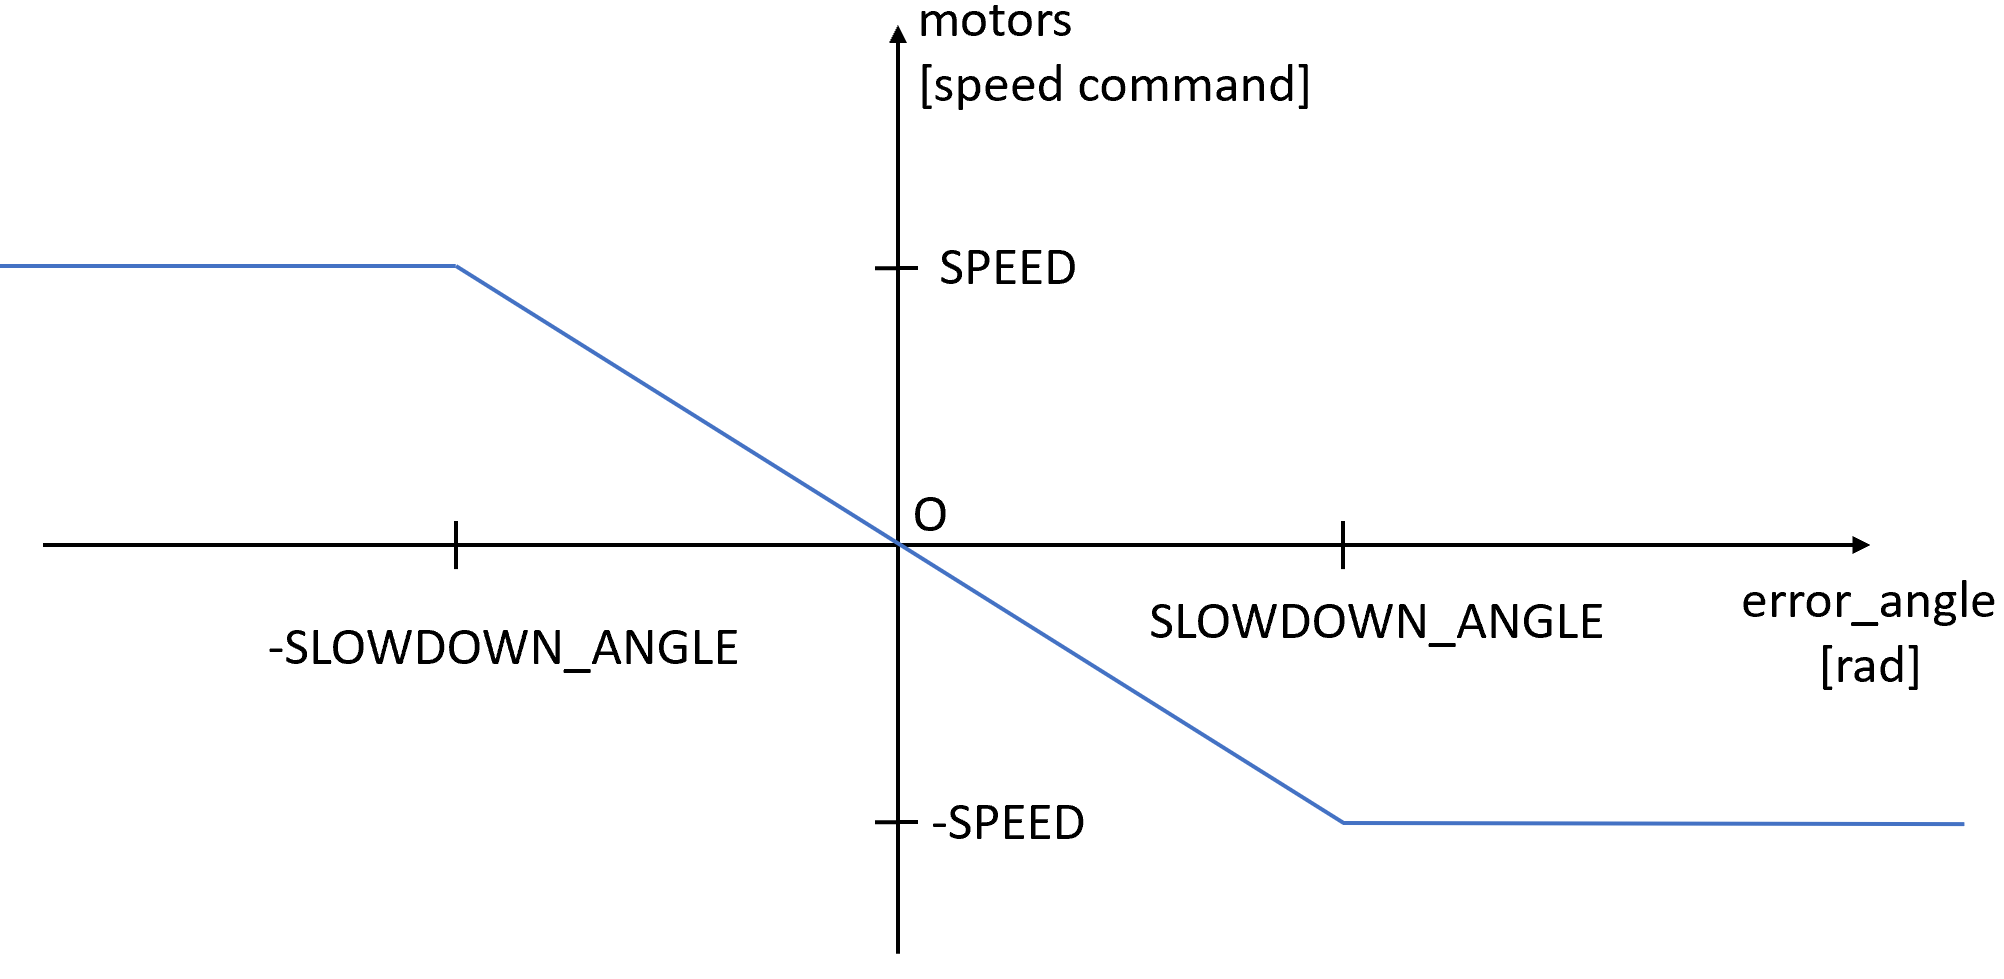

Figure X Speed representation when the error of angles go to zero

The code below is the implementation of the graph on figure X

In [ ]:
#When an objectif is reached, the robot turn on itself until it reaches the good angle.
def start_angle(angle_r, dep, obj, turn):
    angle_dep_obj = angle(dep, obj)
    error_angle = angle_err(angle_r, angle_dep_obj)
    if abs(error_angle) <= THRESHOLD_ANGLE:
        #small error, goes on        
        turn=False
        motors=np.array([SPEED,SPEED])
    else:
        if optimal_side(angle_r, dep, obj):
            #turns left
            motors=np.array([-SPEED,SPEED])
            if abs(error_angle)<SLOWDOWN_ANGLE:
                motors=np.array([int(-SPEED*abs(error_angle)/SLOWDOWN_ANGLE),int(SPEED*abs(error_angle)/SLOWDOWN_ANGLE)])
            
        else:
            #turns right
            motors=np.array([SPEED,-SPEED])
            if abs(error_angle)<SLOWDOWN_ANGLE:
                motors=np.array([int(SPEED*abs(error_angle)/SLOWDOWN_ANGLE),int(-SPEED*abs(error_angle)/SLOWDOWN_ANGLE)])
                
        turn=True
    return motors, turn

### Local navigation <a class="anchor" id="localnavigation">
The local navigation is directly done on the Thymio and has a higher priority than the commands sent by the computer. It is used to avoid the obstacle on Thymio's path. When the front proximity sensors detect an obstacle, the Thymio will turn according to the value of the sensors until it does not detect the obstacle anymore. After that, the Thymio will continue to move forward for a short time to avoid it to go back in the obstacle because of the PD regulator.
Limitations : If the obstacle is really in the center of the way of the Thymio, it will turn and go too far of its way so that the regulator will not be able to bring the Thymio back on its path.

In [ ]:
import tdmclient.notebook
import numpy as np
await tdmclient.notebook.start()

In [ ]:
%%run_python
timer_period[0] = 10  # 10ms sampling time
timer=0
@onevent 
def timer0():
    global prox_horizontal, motor_left_target, motor_right_target, timer
    SPEED=100
    PROX_FACTOR=80
    THRESHOLD_PROX=50
    if prox_horizontal[0]>THRESHOLD_PROX or prox_horizontal[1]>THRESHOLD_PROX:
        #Should turn right
        motor_left_target=(SPEED+prox_horizontal[0]//PROX_FACTOR+prox_horizontal[1]//PROX_FACTOR)
        motor_right_target=(SPEED-prox_horizontal[0]//PROX_FACTOR-prox_horizontal[1]//PROX_FACTOR)
        timer=200
    elif prox_horizontal[4]>THRESHOLD_PROX :
        #Should turn left
        motor_left_target=(SPEED-prox_horizontal[4]//PROX_FACTOR-prox_horizontal[3]//PROX_FACTOR)
        motor_right_target=(SPEED+prox_horizontal[4]//PROX_FACTOR+prox_horizontal[3]//PROX_FACTOR)
        timer=200
    elif prox_horizontal[3]>THRESHOLD_PROX:
        #Should turn left
        motor_left_target=(SPEED-prox_horizontal[4]//PROX_FACTOR-prox_horizontal[3]//PROX_FACTOR)
        motor_right_target=(SPEED+prox_horizontal[4]//PROX_FACTOR+prox_horizontal[3]//PROX_FACTOR)
        timer=200
    else:
        if timer>0:
            timer=timer-1
            motor_left_target=SPEED
            motor_right_target=SPEED
        else:
            timer=0
    
@onevent
def button_center():
    global motor_left_target, motor_right_target
    motor_left_target=0
    motor_right_target=0

In [ ]:
await tdmclient.notebook.stop()

### Conclusion

Combining all the modules helped Santo to save Christmas ! Just run the cell below to see the result !

### Sources :
[1] Caleiro, P. M. R., Neves, A. J. R., & Pinho, A. J. (2007). Color-spaces and color segmentation for real-time object recognition in robotic applications. 4, 6.

[2] Tracking white color using python opencv. (n.d.). NewbeDEV. Retrieved December 9, 2021, from https://newbedev.com

[3] The Shapely User Manual—Shapely 1.8.0 documentation. (n.d.). Retrieved December 9, 2021, from https://shapely.readthedocs.io/en/stable/manual.html